In [125]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [126]:
corpus = pd.read_csv('../data/corpus/ukr_news_2023_1M-words.txt', 
                     sep='\t', 
                     header=None, 
                     index_col=0)
corpus.columns = ['word', 'count']
# lower case
corpus['word'] = corpus['word'].str.lower()
# join identical words and sum their counts
corpus = corpus.groupby('word', as_index=False).sum()

In [127]:
# convert counts into frequencies
corpus['frequency'] = corpus['count'] / corpus['count'].sum()

In [128]:
slovotvir = pd.read_csv('../data/words_translations_cleaned.csv')

In [129]:
# # get top-100 most liked translations
# top_100 = slovotvir.sort_values('rating', ascending=False).head(100)['translation_body'].values

In [143]:
# # get top-100 most liked translations and corresponding words
top_100_w = slovotvir.sort_values('rating', ascending=False)[['word_body', 'translation_body']]

In [144]:
words = top_100_w.word_body.unique()
# for each word, extract the translations and store them in a list with their rank (i.e. index in the list based on ranking)
translations = []

for word in words:
    translations.append(slovotvir[slovotvir['word_body'] == word].sort_values('rating', ascending=False)['translation_body'].values)

In [145]:
# create a dataframe from translations with corresponding words and rank (i.e. index in the list based on ranking)

translations = pd.DataFrame(translations, index=words).stack().reset_index()
translations.columns = ['word', 'rank', 'translation']

In [147]:
# for each translation, get the frequency of the translation in the corpus
translations['frequency'] = translations['translation'].map(corpus.set_index('word')['frequency'])

In [148]:
translations.dropna(subset=['frequency'], inplace=True)

In [149]:
translations.shape

(10543, 4)

In [150]:
# normalize rank inside each word - mean / std

# translations['rank'] = (translations['rank'] - translations.groupby('word')['rank'].transform('mean')) / translations.groupby('word')['rank'].transform('std')

In [151]:
translations['log_frequency'] = np.log(translations['frequency'])

In [152]:
translations.dropna(subset=['rank'], inplace=True)

In [153]:
# find which of the words is most frequently used

translations['word_frequency'] = translations['word'].map(corpus.set_index('word')['frequency'])

In [154]:
translations.dropna(subset=['word_frequency'], inplace=True)

In [158]:
# fit a model predicting frequency from slovotvir rank with word as a random effect

import statsmodels.api as sm

md = sm.MixedLM.from_formula("log_frequency ~ rank",
                                groups='word',
                                data=translations)

In [159]:
# fit the model
mdf = md.fit()

print(mdf.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_frequency
No. Observations: 7611    Method:             REML         
No. Groups:       2998    Scale:              1.8292       
Min. group size:  1       Log-Likelihood:     -13249.7070  
Max. group size:  28      Converged:          Yes          
Mean group size:  2.5                                      
-----------------------------------------------------------
             Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept   -12.574    0.020 -619.615 0.000 -12.614 -12.535
rank         -0.009    0.003   -3.154 0.002  -0.014  -0.003
word Var      0.075    0.016                               



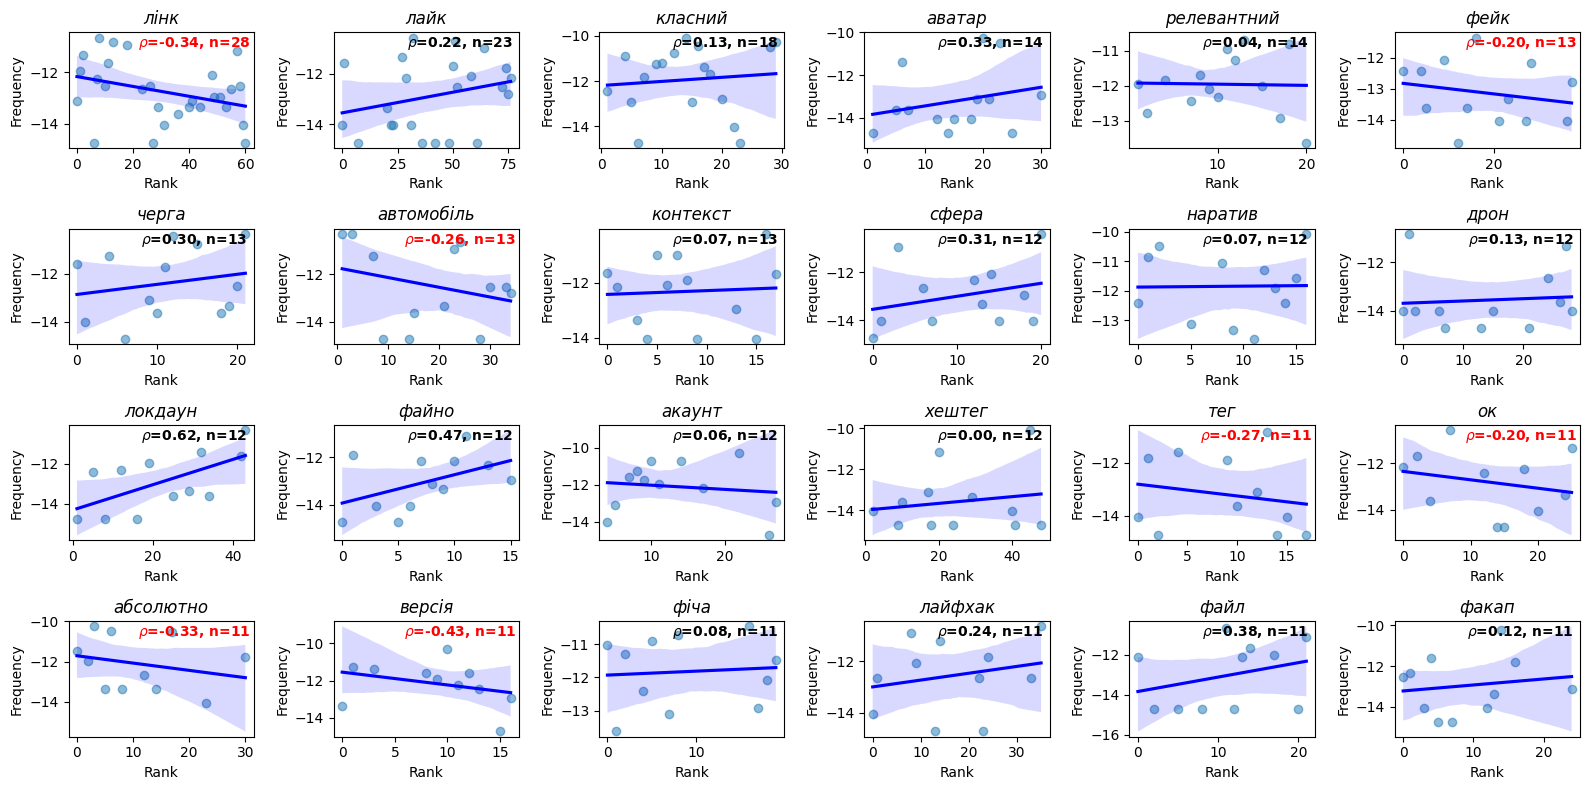

In [164]:
fig, axes = plt.subplots(4, 6, figsize=(16, 8))  # 5 rows, 2 columns

# words_to_plot = translations['word'].value_counts().head(24).index.to_list()
# most common words with the most translations
# words_to_plot = translations['word'].value_counts().head(500).index.to_list()
# [translations['word'].isin(words_to_plot)]
words_to_plot = translations.groupby('word').size().sort_values(ascending=False).head(24).index.to_list()

for ax, word in zip(axes.flatten(), words_to_plot):
    subset = translations.query(f'word == "{word}"')
    ax.scatter(subset['rank'], subset['log_frequency'],
               alpha=0.5)
    # add a reg plot
    sns.regplot(x='rank', y='log_frequency', 
                data=subset, ax=ax, 
                scatter=False, color='blue')
    # add spearmans rho on the top right corner
    rho = subset['rank'].corr(subset['log_frequency'], method='spearman')
    color = 'red' if rho < 0 else 'black'
    ax.text(0.68, 0.9, fr'$\rho$={rho:.2f}, n={len(subset)}', 
            horizontalalignment='center', 
            verticalalignment='center', 
            transform=ax.transAxes,
            fontweight='bold',
            color=color)
    ax.set_title(word, # italic font
                 fontstyle='italic')
    ax.set_xlabel('Rank')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()